In [176]:
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
import scipy as sc
import datetime
import Utilities
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from GraRep.GraRep import GraRep
from Node2Vec.Node2Vec import Node2Vec
from GraphWave.GraphWave import GraphWave
import math

np.random.seed(123)



In [2]:
def plot_networkx(graph, role_labels):
        cmap = plt.get_cmap('hot')
        x_range = np.linspace(0, 1, len(np.unique(role_labels)))
        coloring = {u: cmap(x_range[i]) for i, u in enumerate(np.unique(role_labels))}
        node_color = [coloring[role_labels[i]] for i in range(len(role_labels))]
        plt.figure()
        nx.draw_networkx(graph, pos=nx.layout.fruchterman_reingold_layout(graph),
                         node_color=node_color, cmap='hot')
        plt.show()
        return

In [3]:
def barbel_graph(start, n1, n2, role_start=0, plot=False):
    '''Creates a Barbell-graph (two dense components connected by a stringraph)
    on n1 and n2 nodes
    INPUT:
    -------------
    start       :    starting index for the shape
    n1, n2      :    n1: size of the cliques and  2*n2= size of the string
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    role_labels :    list of the roles of the nodes (indexed starting at
    '''

    a1 = np.ones((n1, n1))
    np.fill_diagonal(a1, 0)         # set the diagonal to 0
    graph = nx.from_numpy_matrix(a1)
    a2 = np.ones((n1, n1))
    block_zeros = np.zeros((n1, n1))
    a = np.bmat([[a1, block_zeros], [block_zeros, a2]])
    np.fill_diagonal(a, 0)          # set the diagonal to 0
    graph = nx.from_numpy_matrix(a)
    start = nx.number_of_nodes(graph)
    graph.add_nodes_from(range(start, start + 2 * n2 + 1))
    string = [(i, i + 1) for i in range(start, start + 2 * n2)]
    graph.add_edges_from(string)
    graph.add_edges_from([(0, start), (n1, start + 2 * n2)])
    role_labels = [0] * (2 * n1)
    role_labels[0] = 1
    role_labels[n1] = 1
    str_role = [i for i in range(2, n2 + 2)]
    str_role.append(n2+2)
    str_role += [n2+3-i for i in range(2, n2+2)]
    role_labels += str_role
    if plot is True: plot_networkx(graph, role_labels)
    return graph, role_labels


def clique(start, nb_nodes, nb_to_remove=0, role_start=0, plot=False):
    ''' Defines a clique (complete graph on nb_nodes nodes,
    with nb_to_remove  edges that will have to be removed),
    index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    nb_nodes    :    int correspondingraph to the nb of nodes in the clique
    role_start  :    starting index for the roles
    nb_to_remove:    int-- numb of edges to remove (unif at RDM)
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    a = np.ones((nb_nodes, nb_nodes))
    np.fill_diagonal(a, 0)
    graph = nx.Graph()
    graph = nx.from_numpy_matrix(a)
    edge_list = graph.edges().keys()
    roles = [role_start] * nb_nodes
    if nb_to_remove > 0:
        lst = np.random.choice(len(edge_list), nb_to_remove, replace=False)
        print(edge_list, lst)
        to_delete = [edge_list[e] for e in lst]
        graph.remove_edges_from(to_delete)
        for e in lst:
            print(edge_list[e][0])
            print(len(roles))
            roles[edge_list[e][0]] += 1
            roles[edge_list[e][1]] += 1
    mapping_graph = {k: (k + start) for k in range(nb_nodes)}
    graph = nx.relabel_nodes(graph, mapping_graph)
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def cycle(start, len_cycle, role_start=0, plot=False):
    '''Builds a cycle graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + len_cycle))
    for i in range(len_cycle-1):
        graph.add_edges_from([(start + i, start + i + 1)])
    graph.add_edges_from([(start + len_cycle - 1, start)])
    roles = [role_start] * len_cycle
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def diamond(start, role_start=0, plot=False):
    '''Builds a diamond graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 6))
    graph.add_edges_from([(start, start + 1), (start + 1, start + 2),
                          (start + 2, start + 3), (start + 3, start)])
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1),
                          (start + 4, start + 2), (start + 4, start + 3)])
    graph.add_edges_from([(start + 5, start), (start + 5, start + 1),
                          (start + 5, start + 2), (start + 5, start + 3)])
    roles = [role_start] * 6
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def fan(start, nb_branches, role_start=0, plot=False):
    '''Builds a fan-like graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    nb_branches :    int correspondingraph to the nb of fan branches
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph, roles = star(start, nb_branches, role_start=role_start)
    for k in range(1, nb_branches - 1):
        roles[k] += 1
        roles[k + 1] += 1
        graph.add_edges_from([(start + k, start + k + 1)])
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def hollow(start, role_start=0, plot=False):
    ''' Creates a torus-like basis structure where the
    index of nodes start at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
    '''
    graph1, _ = cycle(start, 5)
    graph, _ = cycle(start + 5, 10)
    graph.add_nodes_from(graph1.nodes())
    graph.add_edges_from(graph1.edges())
    graph.add_edges_from([(start, start + 5), (start + 1, start + 7),
                          (start + 2, start + 9), (start + 3, start + 11),
                          (start + 4, start + 13)])
    graph.add_edges_from([(start + 6, start + 1), (start + 6, start)])
    graph.add_edges_from([(start + 8, start + 2), (start + 8, start + 1)])
    graph.add_edges_from([(start + 10, start + 3), (start + 10, start + 2)])
    graph.add_edges_from([(start + 12, start + 4), (start + 12, start + 3)])
    graph.add_edges_from([(start + 14, start), (start + 14, start + 4)])
    roles = [role_start] * nx.number_of_nodes(graph)
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def house(start, role_start=0, plot=False):
    '''Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from([(start, start + 1), (start + 1, start + 2),
                          (start + 2, start + 3), (start + 3, start)])
    graph.add_edges_from([(start, start + 2), (start + 1, start + 3)])
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1,
             role_start + 1, role_start + 2]
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def karate_club(plot=False):
    '''
    Defines the mirrored- Karate network structure ( KDD paper)
    '''
    graph1 = nx.karate_club_graph()
    a = nx.adjacency_matrix(graph1)
    n_graph = nx.number_of_nodes(graph1)
    b = np.zeros((n_graph, n_graph))
    a = np.bmat([[a.todense(), b], [b, a.todense()]])
    graph = nx.from_numpy_matrix(a)
    # add link between two random members
    roles = range(n_graph)
    roles += range(n_graph)
    graph.add_edges_from([(0, 36)])
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def mirrored_cavemen(n, k, plot=False):
    '''Builds a mirrored_cavemen graph
    INPUT:
    -------------
    n           :    number of nodes
    k           :    number of cliques
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    n_graph = n * k
    a = np.ones((k, k))
    np.fill_diagonal(a, 0)
    adj = sc.linalg.block_diag(*([a] * n))
    for i in range(n-1):
        adj[(i + 1) * k - 1, (i + 1) * k] = 1
        adj[(i + 1) * k, (i + 1) * k - 1] = 1
    adj[n * k - 1, 0] = 1
    adj[0, n * k - 1] = 1
    graph = nx.from_numpy_matrix(adj)
    roles = [0] * n_graph
    for i in range(n-1):
        roles[(i + 1) * k - 1] = 1
        roles[(i + 1) * k] = 1
    roles[0] = 1
    roles[n * k - 1] = 1
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def star(start, nb_branches, role_start=0, plot=False):
    '''Builds a star graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    nb_branches :    int correspondingraph to the nb of star branches
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + nb_branches + 1))
    for k in range(1, nb_branches + 1):
        graph.add_edges_from([(start, start + k)])
    roles = [role_start + 1] * (nb_branches + 1)
    roles[0] = role_start
    if plot is True: plot_networkx(graph, roles)
    return graph, roles


def string(start, width, role_start=0):
    '''Builds a stringraph graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    width       :    int correspondingraph to the lengraphth of the stringraph
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + width))
    for i in range(width - 1):
        graph.add_edges_from([(start + i, start + i + 1)])
    roles = [role_start] * width
    roles[0] = role_start + 1
    roles[-1] = role_start + 1
    return graph, roles


def tree(start, nb_levels, regularity, role_start=0, plot=False):
    ''' Defines a clique (complete graph on nb_nodes nodes,
    with nb_to_remove  edges that will have to be removed),
    index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    nb_levels   :    int correspondingraph to the nb of levels in the tree
    regularity  :    nb of children for each node
    role_start  :    starting index for the roles
    plot        :    boolean -- should the shape be printed?
    OUTPUT:
    -------------
    graph           :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    '''
    graph = nx.Graph()
    nodes_level = [regularity**l for l in range(nb_levels)]
    graph.add_nodes_from(range(start, start + np.sum(nodes_level)))
    a = start
    it = 0
    for n in range(1, np.sum(nodes_level)):
        graph.add_edges_from([(a, start + n)])
        it += 1
        if it == (regularity):
            a += 1
            it = 0

    n = nx.number_of_nodes(graph)
    roles = [role_start + 1] * nx.number_of_nodes(graph)
    roles[0] = role_start
    for i in range(regularity**l):
        roles[n - 1 - i] += 1
    if plot is True: plot_networkx(graph, roles)
    return graph, roles




In [4]:

def build_structure(width_basis, basis_type, list_shapes, start=0,
                    rdm_basis_plugins =False, add_random_edges=0,
                    plot=False, savefig=False):
    '''This function creates a basis (torus, string, or cycle)
    and attaches elements of the type in the list randomly along the basis.
    Possibility to add random edges afterwards.
    INPUT:
    --------------------------------------------------------------------------------------
    width_basis      :      width (in terms of number of nodes) of the basis
    basis_type       :      (torus, string, or cycle)
    shapes           :      list of shape list (1st arg: type of shape,
                            next args:args for building the shape,
                            except for the start)
    start            :      initial nb for the first node
    rdm_basis_plugins:      boolean. Should the shapes be randomly placed
                            along the basis (True) or regularly (False)?
    add_random_edges :      nb of edges to randomly add on the structure
    plot,savefig     :      plotting and saving parameters
    OUTPUT:
    --------------------------------------------------------------------------------------
    basis            :       a nx graph with the particular shape
    colors           :       labels for each role
    '''
    basis, role_id = eval(basis_type)(start, width_basis)
    n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)
    start += n_basis        # indicator of the id of the next node

    # Sample (with replacement) where to attach the new motives
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(width_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]
    communities = [0] * n_basis
    seen_shapes = {'basis': [0, n_basis]}
    for p in plugins:
        role_id[p] += 1

    for shape_id, shape in enumerate(list_shapes):
        shape_type = shape[0]
        args = [start]
        if len(shape)>1:
            args += shape[1:]
        args += [0]
        graph_s, roles_graph_s = eval(shape_type)(*args)
        n_s = nx.number_of_nodes(graph_s)
        try:
            col_start = seen_shapes[shape_type][0]
        except:
            col_start = np.max(role_id) + 1
            seen_shapes[shape_type] = [col_start, n_s]
        # Attach the shape to the basis
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        basis.add_edges_from([(start, plugins[shape_id])])
        role_id[plugins[shape_id]] += (-2 - 10 * seen_shapes[shape_type][0])
        communities += [shape_id] * n_s
        temp_labels = [r + col_start for r in roles_graph_s]
        temp_labels[0] += 100 * seen_shapes[shape_type][0]
        role_id += temp_labels
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        for p in range(add_random_edges):
            src, dest = np.random.choice(nx.number_of_nodes(basis),
                                         2, replace=False)
            print(src, dest)
            basis.add_edges_from([(src, dest)])
    if plot is True: plot_networkx(basis, role_id)

    return basis, communities, plugins, role_id

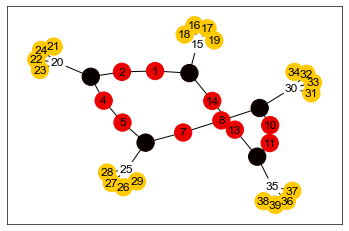

In [152]:
width_basis = 15
#nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 5  ## numbers of shapes to add 
shape = "star"
#shape=["star",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
list_shapes = [[shape,4]] * n_shapes

### 3. Give a name to the graph
identifier = "_" + basis_type   ## just a name to distinguish between different trials
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
add_edges = 0
G, communities, _ , role_id = build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=True,
                                       savefig=False)
name_graph = str(width_basis) + basis_type + str(n_shapes) + shape + "_" + str(datetime.datetime.now())[-3:]

Teraz zapisujesz graf do pliku i w nazwie są wszystkie potrzebne parametry żeby potem ten graf odtworzyć

In [105]:
A = nx.adjacency_matrix(G)
B = A.toarray()

Utilities.save_matrix(B, "Graphs\\AdjacencyMatrixes\\GraphWave_Graphs\\" + name_graph+".txt")

C:\Users\grycz\AppData\Local\Temp\ipykernel_14052\3154930693.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


## GraphWave

In [135]:
matrix = input("Give path to adjacency matrix: ")
GW = GraphWave(matrix,10)
chi = GW.create_embedding(10,0,1)


## GraRep

In [67]:
matrix = input("Give path to adjacency matrix: ")
k = input("Give maximum transition step: ")
d = input("Give embedding dimension: ")
GR = GraRep(matrix, int(k), int(d))
chi2 = GR.create_embedding()

## Node2Vec

In [74]:
matrix = input("Give path to adjacency matrix: ")
le = int(input("Give length of a single random walk: "))
r = int(input("Give number of random walks starting at a single vertex: "))
p = float(input("Give bias Return parameter: "))
q = float(input("Give bias In-Out parameter: "))
d = int(input("Give embedding dimension: "))
NV = Node2Vec(matrix, int(le), int(r), int(p), int(q), int(d))
chi3 = NV.create_embedding()

TypeError: __init__() got an unexpected keyword argument 'size'

In [132]:
def plot_pca(chi, m):
    df = pd.DataFrame(np.array(np.array(chi).transpose()))
    X = df
    Y = role_id
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2)
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    print('Logistic Regression score: ', model.score(X_test, Y_test))
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.2)
    model = LogisticRegression()
    model.fit(X_train_pca, Y_train)
    print("PCA score: ", model.score(X_test_pca, Y_test))
    a, b = X_pca.transpose()
    markers = m
    nb_clust = len(np.unique(role_id))
    x=np.linspace(0,1,nb_clust+1)
    cmapx=plt.get_cmap('rainbow')
    col=[cmapx(xx) for xx in x ]
    for i in range(len(role_id)):
        # plt.xlim(-0.0007, 0.0002)
        # plt.ylim(-0.0002,0.00004)
        plt.scatter(a[i],b[i], marker=markers[role_id[i]])
        # if i%2 == 0:
        #     plt.show()
    plt.show()


In [115]:
np.unique(role_id)

array([-21,   0,   2,   3,   4, 202])

sprawdzasz sobie jakie są role_id i żeby w tym m były takie same

jak nie działa to zamień na np.array(chi).transpose()

Logistic Regression score:  1.0
PCA score:  0.625


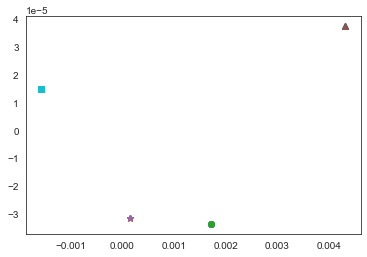

In [151]:
m = {0:'*',-21: 'o',2: '1' , 3: ',',4: '2' , 202: '^'}
plot_pca(np.array(chi), m)